# Information Retrieval in High Dimensional Data
## Lab 5

|     |     |
| --- | --- |
| **Name:** | Uzair Akbar |
| **Matriculation Number:** | 03697290 |
| **E-mail:** | [uzair.akbar@tum.de](mailto:uzair.akbar@tum.de) |

## Principal Component Analysis
### Task 1
In this task, we will once again work with the MNIST training set as provided on Moodle. Choose three digit classes, e.g. 1, 2 and 3 and load `N=1000` images from each of the classes to the workspace. Store the data in a normalized matrix `X` of size `(784,3*N)`. Furthermore, generate a color label matrix `C` of dimensions `(3*N,3)`. Each row of `C` assigns an RGB color vector to the respective column of X as an indicator of the digit class. Choose `[0, 0, 1].T`, `[0,1, 0]` and `[1, 0, 0]` for the three digit classes.

In [9]:
import numpy as np
import imageio

N=1000
digit_prefix=['d1','d2','d3']
X=np.zeros((784,3*N))
C=np.zeros((3*N,3))
for i,dp in enumerate(digit_prefix):
    val_rgb=np.zeros((3,))
    val_rgb[i]=1.0
    for j in range(N):
        X[:,i*N+j]=np.float64(imageio.imread('mnist/'+dp+'/'+dp+'_'+'%04d.png'%(j+1)).ravel())
        C[i*N+j]=val_rgb


**a)** Compute the row-wise mean `mu` of `X` and subtract it from each column of `X`. Save the results as `X_c`.

In [10]:
mu=np.mean(X,axis=1)
X_c=X-np.expand_dims(mu,axis=1) # expand dims to ensure correct broadcasting

**b)** Use `np.linalg.svd` with `full_matrices=False` to compute the singular value decomposition `[U,Sigma,VT]` of `X_c`

In [11]:
[U,Sigma,VT]=np.linalg.svd(X_c,full_matrices=False)

**c)** Use `reshape` in order to convert `mu` and the first three columns of `U` to `(28,28)`-matrices. Plot the resulting images. What do you see?

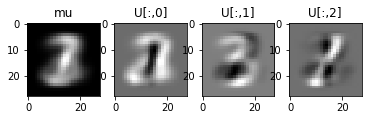

In [12]:
import matplotlib.pyplot as plt

plt.subplot(1,4,1)
plt.imshow(mu.reshape(28,28), cmap='gray')
plt.title('mu')
plt.subplot(1,4,2)
plt.imshow(U[:,0].reshape(28,28), cmap='gray')
plt.title('U[:,0]')
plt.subplot(1,4,3)
plt.imshow(U[:,1].reshape(28,28), cmap='gray')
plt.title('U[:,1]')
plt.subplot(1,4,4)
plt.imshow(U[:,2].reshape(28,28), cmap='gray')
plt.title('U[:,2]')
plt.show()

**d)** Compute the matrix `S=np.dot(np.diag(Sigma),V.T)`. Note that his yields the same result as `S=np.dot(U.T,X_c)`. The `S` matrix contains the `3*N` scores for the principal components `1` to `784`. Create a 2D scatter plot with `C` as its color parameter in order to plot the scores for the first two principal components of the data.

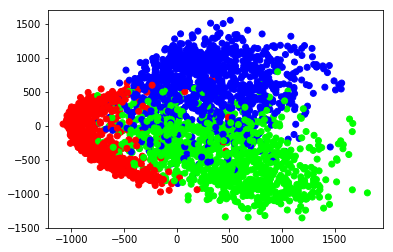

In [13]:
S=np.expand_dims(Sigma,axis=1)*VT

#reorder indexes for visualization purposes
idx_new=((np.arange(3*N).reshape(3,N).T).reshape(N,3)).ravel()
plt.scatter(S[0,idx_new],S[1,idx_new],c=C[idx_new])
plt.show()

### Task 2
In this task, we consider the problem of choosing the number of principal vectors. Assuming that $\mathbf{X} \in \mathbb{R}^{p \times N}$ is the centered data matrix and $\mathbf{P} = \mathbf{U}_k \mathbf{U}_k^\top$ is the projector onto the $k$-dimensional principal subspace, the dimension $k$ is chosen such that the fraction of overall energy contained in the projection error does not exceed $\epsilon$, i.e.\
	\begin{equation*}
	    \frac{\|\mathbf{X} - \mathbf{PX}\|_F^2}{\|\mathbf{X}\|_F^2} 
	    = \frac{\sum_{i=1}^{M} \|\mathbf{x}_i - \mathbf{Px}_i\|^2}{\sum_{i=1}^N \|\mathbf{x}_i\|^2} \leq \epsilon,
	\end{equation*}
where $\epsilon$ is usually chosen to be between 0.01 and 0.2.
	
The MIT VisTex database as provided on Moodle consists of a set of 167 RGB texture images of sizes `(512,512,3)`. Download the ZIP file, unpack it and make yourself familiar with the directory strucutre.

**a)** After preprocessing the entire image set (converting to normalized grayscale matrices), divide the images into non overlapping tiles of sizes `(64,64)` and create a centered data matrix `X_c` of size `(p,N)` from them, where `p=64*64` and `N=167*(512/64)*(512/64)`.

In [14]:
import os, glob

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

# define data directory
data_dir = './VisTex_512_512'

# change to correct directory
files = glob.glob(data_dir+'/*.ppm')

# define number of files
N = len(files)

p=64**2
n = np.uint16(N*512**2/p)


# initialize array to store data
X = np.zeros((p, n))
im_count = 0
# import texture data
for f in files:
    img = imageio.imread(f)
    img = rgb2gray(np.array(img)/255.0)
    for k in range(0,8):
        for j in range(0,8):
            x_tmp = img[k*64:(k+1)*64, j*64:(j+1)*64].ravel()
            X[:,np.uint16(im_count*(512/64)**2 + k*8 + j)] = x_tmp
    im_count +=1

#%% center data
mu = np.mean(X, axis=1)
X_c = X - np.expand_dims(mu, 1)

**b)** Compute the SVD of `X_c` and make sure the output eigenvalues are sorted in descending order.

In [15]:
[U_vt,Sigma_vt,V_vt]=np.linalg.svd(X_c, full_matrices=False)

**c)** Plot the fraction of energy contained in the projection error for the principal subspace dimensions `0` to `p`. How many principal vectors do you need to retain 80%, 90%, 95% or 99% of the original data energy?

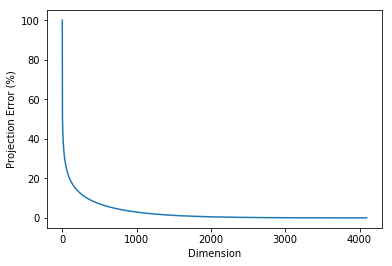

Required dimension of subspace for Preservation of 80% of the energy: 98.0
Required dimension of subspace for Preservation of 90% of the energy: 335.0
Required dimension of subspace for Preservation of 95% of the energy: 694.0
Required dimension of subspace for Preservation of 99% of the energy: 1651.0


In [16]:
p_steps=np.arange(p+1)
proj_error=np.array([(1.0-np.sum(Sigma_vt[:i]**2)/np.sum(Sigma_vt**2))*100.0 for i in p_steps])
plt.plot(p_steps,proj_error)
plt.xlabel('Dimension'); plt.ylabel('Projection Error (%)')
plt.show()

print('Required dimension of subspace for Preservation of 80% of the energy:', np.sum(np.uint16(proj_error>=20))+1)
print('Required dimension of subspace for Preservation of 90% of the energy:', np.sum(np.uint16(proj_error>=10))+1)
print('Required dimension of subspace for Preservation of 95% of the energy:', np.sum(np.uint16(proj_error>=5))+1)
print('Required dimension of subspace for Preservation of 99% of the energy:', np.sum(np.uint16(proj_error>=1))+1)

**d)** Discuss: Can you imagine a scenario, where energy is a bad measure of useful information?
***

A typical situation that arises with machine learning on natural images is that lighting conditions vary heavily. Often, the overall brightness of a picture does not add any discriminative value to it. For instance, a face recognition system should not care about whether a picture was taken at day or at night. However, if the overall brighness varies over a set of images that is processed by PCA, the first principal components will mostly contain the brightness information.